# Digit Recognizer

Target: Take an image of a handwritten single digit, and determine what that digit is.

Source: https://www.kaggle.com/c/digit-recognizer

In [1]:
# data manipulation
import numpy as np
import random

# high-level neural networks API - running on top of TensorFlow
import keras
from keras.datasets import mnist 
# Sequential is a linear stack of layers
from keras.models import Sequential
# Dense, Flatten - type of layers, Dropout - tool, which decrease chance of overfitting
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K

# data visualisation, live training loss plot
import matplotlib.pyplot as plt
import livelossplot

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [ ]:
def vis_rand_dig():
    # size of pixcel
    plt.figure(figsize = (10, 10))
    # print random digit
    rand_indexes = np.random.randint(0, X_train.shape[0], 16)
    for index,im_index in enumerate(rand_indexes):
        plt.subplot(4, 4, index+1)
        plt.imshow(X_train[im_index], cmap = 'ocean', interpolation = 'none')
        plt.title('Class %d' % y_train[im_index])
    plt.tight_layout()

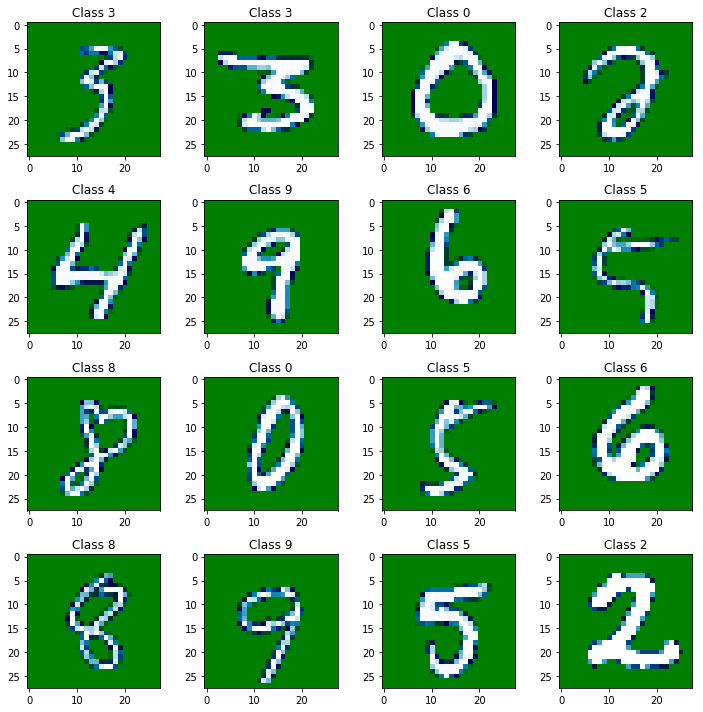

In [ ]:
vis_rand_dig()

# CNN

Convolutional neural network expects additional parameter - number of channels. In computer science we have two type of standards. We may add channel at the first or last element. It is dependent on backend. I use TensorFlow, so I add channel at last.

In [ ]:
def prep_data(X_tr, X_ts, y_tr, y_ts):
    print(X_tr.shape, X_ts.shape)
    # channel_last
    if K.image_data_format() == 'channels_last':
        
        X_tr = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], X_tr.shape[2], 1)
        X_ts = X_ts.reshape(X_ts.shape[0], X_ts.shape[1], X_ts.shape[2], 1)
        in_cnn = (X_tr.shape[1], X_tr.shape[2], 1)

        print(in_cnn)
        print(X_tr.shape, X_ts.shape)
   
    if len(X_tr.shape) == 4:
        
        X_tr = X_tr.astype('float32') / 255
        X_ts = X_ts.astype('float32') / 255
    
    y_tr = keras.utils.np_utils.to_categorical(y_tr)
    y_ts = keras.utils.np_utils.to_categorical(y_ts)
    
    classes = y_tr.shape[1]

    return X_tr, y_tr, X_ts, y_ts, in_cnn, classes

In [ ]:
X_train, y_train, X_test, y_test, in_dim, out_dim = prep_data(X_train, X_test, y_train, y_test)

(60000, 28, 28) (10000, 28, 28)
(28, 28, 1)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
def cnn():
    cnn = Sequential([
        Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = in_dim),
        Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        Dropout(0.5),
        Dense(out_dim, activation = 'softmax')
    ])
    return cnn

model = cnn()
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam' , metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [1]:
%%time
# learning curve, which draws live
# https://github.com/stared/livelossplot 

plot_losses = livelossplot.PlotLossesKeras()

model.fit(X_train, y_train,
          batch_size = 512,
          epochs = 11,
          validation_data = (X_test, y_test),
          callbacks = [plot_losses],
          verbose = 0);

NameError: name 'livelossplot' is not defined

In [ ]:
result = model.evaluate(X_test, y_test, verbose = 0)
print('Accuracy: ', result[1])
print('Error: %.2f%%' % (100- result[1]*100))

# Where we have mistake?

In [ ]:
y_pred = model.predict(X_test, verbose=0)

In [ ]:
def error_predict(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        yield idx, np.argmax(a), tuple(np.argsort(b)[-2:])

In [ ]:
def display_errors():
    random_errors = random.sample(list(error_predict(y_test, y_pred)), 12)

    plt.figure(figsize=(10, 10))
    X_test_plot = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2] )

    for index, (im_index, y_test_val, (y_pred_2, y_pred_1)) in enumerate(random_errors):
            plt.subplot(4,4,index+1)
            plt.imshow(X_test_plot[im_index], cmap='ocean', interpolation='none')
            plt.title('True value: {0}\nFirst predicted: {1}\nSecond predicted: {2}'.format(y_test_val, y_pred_1, y_pred_2))
            plt.tight_layout()

In [ ]:
display_errors()

In my opiniom model make mistake in very difficult cases.

# Conclusions

- The best score: 0.9952(accuracy), 0,48%(error);
- The best architecture of CNN: 
        Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu',
                input_shape = in_dim),
        Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        Dropout(0.5),
        Dense(out_dim, activation = 'softmax')
        
- Parameters: 1,010,666;
- Time: 16 min 47 s;
- Hardware: CPU - Ryzen 2700X  (I know that GPU is better for deep learning, but I didn't have opportunity to work on GPU);
- Batch size: 512;
- Epochs: 11;

I tried several configuration. The results varied between 0,48% - 0,84% (error). Generally I changed number of layers, number of kernels, size of batch_size and number of epochs. 
I noticed, that: 
- More layer increased computing time and growing number of parameters;
- More batch_size affect the reduced computing time;
- More expanded section of MLP (number of layers and number of neurones) influences on more parameters;
- More CNN layers = less parameters;
- More numbers of epochs affect on growing compute time;
- Worse score after used BatchNormalization;
- CNN vs MLP for digit recognition? Decisively CNN for digit recognizer!